In [1]:
%matplotlib inline

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

import numpy as np

## Generate Data

Normally we would load data from file, but let's just use `sklearn`'s `make_classification` data generator for now.

In [3]:
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)
X

array([[-0.27126113,  1.88663904,  0.4257523 , ...,  0.55820327,
        -0.54562849,  0.12710617],
       [-2.06947249,  1.72056896, -0.64016106, ..., -0.76494431,
        -1.57471131, -0.04753333],
       [-0.20769822, -0.33284919,  1.37265908, ...,  0.03917614,
         0.22502891,  0.90827225],
       ...,
       [ 1.07282353, -0.52578537, -0.87981073, ..., -1.6101395 ,
         0.14297433, -0.50581888],
       [-0.48323585,  0.89892743,  0.00704613, ...,  0.31456258,
        -0.41243498, -0.37286792],
       [ 0.13317063, -0.52905467,  0.91063537, ..., -1.34877197,
         0.63667007, -0.02700027]])

It is important to hold out test data to use below in model evaluation. We don't want any data leakage between our training and testing. `scikit-learn` provides a customizable method for splitting data using indices. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(750, 25)
(250, 25)


## Algorithms 

In [5]:
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
svm.score(X_test_scaled, y_test)

0.724

In [6]:
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale training data
X_train_scaled = scaler.transform(X_train)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train_scaled, y_train)

# scale test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
rfecv.score(X_test_scaled, y_test)

0.796

In [7]:
np.mean(cross_val_score(rfecv, X_train,  y_train, cv=StratifiedKFold(2)))

0.812

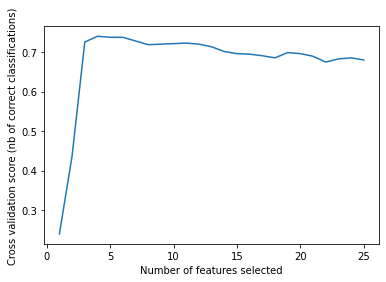

In [8]:
import matplotlib.pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

## Building Pipelines

Using `scikit-learn` transformers consistently is often error prone. Pipelines are used to ensure consistency and prevent data leakage. Below we add preprocessing steps to improve model performance.

In [9]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [10]:
rfecv = RFECV(estimator=SVC(kernel='linear'), step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
pipe = make_pipeline(StandardScaler(), rfecv)

np.mean(cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(2)))

0.8093333333333333

In [11]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), rfecv)
np.mean(cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(2)))

0.8133333333333334

In [12]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.844

## Using Pipelines in Grid Searches

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ploynomial", PolynomialFeatures()),
    ("rfecv", RFECV(estimator=SVC(kernel='linear'), step=1, cv=StratifiedKFold(2),
                    scoring='accuracy',
                    min_features_to_select=min_features_to_select))])
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'ploynomial': [PolynomialFeatures(), None],
    'rfecv__estimator__C': [0.001, 0.1, 1.0, 2.5, 5, 10.0],
    # TODO: Issue with kernel params, pipelines, and gridsearch
    #'rfecv__estimator__kernel': ['rbf', 'poly', 'linear'],
    'rfecv__estimator__shrinking': [True, False],
}
search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(2), n_jobs=-1, refit=True)

In [15]:
%%time

search.fit(X_train, y_train)

CPU times: user 2min 17s, sys: 7min 24s, total: 9min 41s
Wall time: 1min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ploynomial', PolynomialFeatures()),
                                       ('rfecv',
                                        RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                                              estimator=SVC(kernel='linear'),
                                              scoring='accuracy'))]),
             n_jobs=-1,
             param_grid={'ploynomial': [PolynomialFeatures(), None],
                         'rfecv__estimator__C': [0.001, 0.1, 1.0, 2.5, 5, 10.0],
                         'rfecv__estimator__shrinking': [True, False],
                         'scaler': [StandardScaler(), MinMaxScaler()]})

In [16]:
search.best_params_, search.best_score_

({'ploynomial': PolynomialFeatures(),
  'rfecv__estimator__C': 5,
  'rfecv__estimator__shrinking': True,
  'scaler': StandardScaler()},
 0.8213333333333332)

## Evaluate Candidate

In [17]:
best = search.best_estimator_
best

Pipeline(steps=[('scaler', StandardScaler()),
                ('ploynomial', PolynomialFeatures()),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       estimator=SVC(C=5, kernel='linear'),
                       scoring='accuracy'))])

In [18]:
best.score(X_test, y_test)

0.848

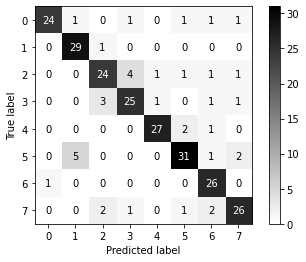

In [19]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best, X_test, y_test, cmap='gray_r')
plt.show()

In [20]:
from sklearn.metrics import classification_report

pred = best.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        29
           1       0.83      0.97      0.89        30
           2       0.80      0.75      0.77        32
           3       0.81      0.81      0.81        31
           4       0.93      0.90      0.92        30
           5       0.86      0.79      0.83        39
           6       0.79      0.96      0.87        27
           7       0.84      0.81      0.83        32

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250

